This module utilizes the following dataset:
https://www.kaggle.com/datasets/michaelbryantds/cpu-and-gpu-product-data

It can either be imported using the code block below or downloaded manually as a .zip file. If you use the code below, make sure to run `pip install kagglehub` first.

All uses of AI-generated code will be clearly labeled.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("michaelbryantds/cpu-and-gpu-product-data")

print("Path to dataset files:", path)

C:\Users\yalts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\yalts\.cache\kagglehub\datasets\michaelbryantds\cpu-and-gpu-product-data\versions\1


Go to the specified path above and copy the file from that folder to the same directory as this Python file.

In [2]:
#Import modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import linregress

In [3]:
#Initial read of the dataset -- remove useless rows (transistor count and release date are required for this analysis), reset indicies, drop weird Unnamed column
chips_df = pd.read_csv('chip_dataset_test.csv').dropna(subset=['Transistors (million)', 'Release Date'], ignore_index=True).drop(columns=['Unnamed: 0'])
chips_df

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD,NaN,NaN,NaN
1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD,NaN,NaN,NaN
2,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.0,80.0,160.0,1400.0,1800.0,Intel,Intel,NaN,NaN,NaN
3,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.0,125.0,258.0,758.0,3700.0,Unknown,AMD,NaN,NaN,NaN
4,Intel Xeon E5-2470 v2,CPU,2013-09-01,22.0,95.0,160.0,1400.0,2400.0,Intel,Intel,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4138,NVIDIA GeForce FX Go5100,GPU,2003-03-01,150.0,NaN,124.0,45.0,200.0,TSMC,NVIDIA,NaN,NaN,NaN
4139,NVIDIA Quadro 3000M,GPU,2011-02-22,40.0,75.0,332.0,1950.0,450.0,TSMC,NVIDIA,NaN,432.0,36.0
4140,NVIDIA GeForce GT 320M,GPU,2010-03-03,40.0,23.0,100.0,486.0,500.0,TSMC,NVIDIA,NaN,52.8,NaN
4141,NVIDIA GeForce FX 5200,GPU,2003-03-06,150.0,NaN,65.0,29.0,250.0,TSMC,NVIDIA,NaN,NaN,NaN


In [4]:
chips_df['Date'] = pd.to_datetime(chips_df['Release Date'])
# Convert date information from string to date format, save in new Date column

chips_df['Year'] = chips_df['Date'].dt.year + (chips_df['Date'].dt.
                                               month - 1) / 12 
# Preserve month information by converting it to a decimal
# (e.g. March 2025 is 2025.333333)

In [5]:
# Select relevant columns and drop missing values
chips_df = chips_df.dropna(subset=['Year'], ignore_index=True).copy()

# Apply logarithmic transformation to make linear analysis possible, like R2 (more on that later)
chips_df['Log Transistor Count'] = np.log2(chips_df['Transistors (million)'])
# Ngl I used AI for a lot of this assignment but this is one of the places it totally FUBARed.
# It applied a base-10 transformation even though Moore's law is a base-2 equation.
# AI is still a long ways away from replacing a programmer with a brain and eyes.

chips_df

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS,Date,Year,Log Transistor Count
0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD,NaN,NaN,NaN,2007-02-20,2007.083333,6.930737
1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD,NaN,NaN,NaN,2018-09-06,2018.666667,12.228819
2,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.0,80.0,160.0,1400.0,1800.0,Intel,Intel,NaN,NaN,NaN,2013-09-01,2013.666667,10.451211
3,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.0,125.0,258.0,758.0,3700.0,Unknown,AMD,NaN,NaN,NaN,2011-05-03,2011.333333,9.566054
4,Intel Xeon E5-2470 v2,CPU,2013-09-01,22.0,95.0,160.0,1400.0,2400.0,Intel,Intel,NaN,NaN,NaN,2013-09-01,2013.666667,10.451211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4073,NVIDIA GeForce FX Go5100,GPU,2003-03-01,150.0,NaN,124.0,45.0,200.0,TSMC,NVIDIA,NaN,NaN,NaN,2003-03-01,2003.166667,5.491853
4074,NVIDIA Quadro 3000M,GPU,2011-02-22,40.0,75.0,332.0,1950.0,450.0,TSMC,NVIDIA,NaN,432.0,36.0,2011-02-22,2011.083333,10.929258
4075,NVIDIA GeForce GT 320M,GPU,2010-03-03,40.0,23.0,100.0,486.0,500.0,TSMC,NVIDIA,NaN,52.8,NaN,2010-03-03,2010.166667,8.924813
4076,NVIDIA GeForce FX 5200,GPU,2003-03-06,150.0,NaN,65.0,29.0,250.0,TSMC,NVIDIA,NaN,NaN,NaN,2003-03-06,2003.166667,4.857981


In [6]:
#Create a simple filter to remove the GPUs and CPUs from the dataset, respectively
gpu_filter = chips_df['Type'] == 'CPU'
cpu_filter = chips_df['Type'] == 'GPU'
#Filter GPUs, save to variable
cpu_df = chips_df.where(gpu_filter).dropna(subset=['Year'], ignore_index=True)
gpu_df = chips_df.where(cpu_filter).dropna(subset=['Year'], ignore_index=True)
#Display new DFs

In [7]:
gpu_df.sort_values(by='Year', ascending=False).head(20)

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS,Date,Year,Log Transistor Count
519,NVIDIA RTX A4000,GPU,2021-04-12,8.0,140.0,392.0,17400.0,735.0,Samsung,NVIDIA,19170.0,19170.0,599.0,2021-04-12,2021.250000,14.086800
2040,NVIDIA A30 PCIe,GPU,2021-04-12,7.0,165.0,826.0,54200.0,930.0,TSMC,NVIDIA,10320.0,10320.0,5161.0,2021-04-12,2021.250000,15.726005
1519,NVIDIA A10G,GPU,2021-04-12,8.0,150.0,628.0,28300.0,1320.0,Samsung,NVIDIA,31520.0,31520.0,985.0,2021-04-12,2021.250000,14.788514
61,NVIDIA A10 PCIe,GPU,2021-04-12,8.0,150.0,628.0,28300.0,885.0,Samsung,NVIDIA,31240.0,31240.0,976.3,2021-04-12,2021.250000,14.788514
258,NVIDIA PG506-232,GPU,2021-04-12,7.0,165.0,826.0,54200.0,930.0,TSMC,NVIDIA,10320.0,10320.0,5161.0,2021-04-12,2021.250000,15.726005
325,NVIDIA RTX A5000,GPU,2021-04-12,8.0,230.0,628.0,28300.0,1170.0,Samsung,NVIDIA,27770.0,27770.0,867.8,2021-04-12,2021.250000,14.788514
733,AMD Radeon RX 6700 XT,GPU,2021-03-03,7.0,230.0,335.0,17200.0,2321.0,TSMC,AMD,26430.0,13210.0,825.9,2021-03-03,2021.166667,14.070121
1490,NVIDIA CMP 40HX,GPU,2021-02-25,12.0,185.0,445.0,10800.0,1470.0,TSMC,NVIDIA,15210.0,7603.0,237.6,2021-02-25,2021.083333,13.398744
1211,NVIDIA CMP 30HX,GPU,2021-02-25,12.0,125.0,284.0,6600.0,1530.0,TSMC,NVIDIA,10050.0,5027.0,157.1,2021-02-25,2021.083333,12.688250
887,AMD Radeon RX 6700,GPU,2021-01-01,7.0,180.0,335.0,17200.0,1489.0,TSMC,AMD,20740.0,10370.0,648.0,2021-01-01,2021.000000,14.070121


In [8]:
cpu_df.sort_values(by='Year', ascending=False).head(20)

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS,Date,Year,Log Transistor Count
1050,AMD Ryzen 7 5800H,CPU,2021-01-12,7.0,54.0,156.0,9800.0,3200.0,TSMC,AMD,NaN,NaN,NaN,2021-01-12,2021.000000,13.258566
50,AMD Ryzen 9 5900HX,CPU,2021-01-12,7.0,45.0,156.0,9800.0,3300.0,TSMC,AMD,NaN,NaN,NaN,2021-01-12,2021.000000,13.258566
1646,AMD Ryzen 9 5980HS,CPU,2021-01-12,7.0,35.0,156.0,9800.0,3000.0,TSMC,AMD,NaN,NaN,NaN,2021-01-12,2021.000000,13.258566
1309,AMD Ryzen 7 5800HS,CPU,2021-01-12,7.0,35.0,156.0,9800.0,2800.0,TSMC,AMD,NaN,NaN,NaN,2021-01-12,2021.000000,13.258566
65,AMD Ryzen 5 5500U,CPU,2021-01-12,7.0,25.0,156.0,9800.0,2100.0,TSMC,AMD,NaN,NaN,NaN,2021-01-12,2021.000000,13.258566
59,AMD Ryzen Threadripper PRO 3955WX,CPU,2020-07-14,7.0,280.0,74.0,3800.0,3900.0,TSMC,AMD,NaN,NaN,NaN,2020-07-14,2020.500000,11.891784
1459,AMD Ryzen Threadripper PRO 3975WX,CPU,2020-07-14,7.0,280.0,74.0,3800.0,3500.0,TSMC,AMD,NaN,NaN,NaN,2020-07-14,2020.500000,11.891784
1460,AMD Ryzen Threadripper PRO 3945WX,CPU,2020-07-14,7.0,280.0,74.0,3800.0,4000.0,TSMC,AMD,NaN,NaN,NaN,2020-07-14,2020.500000,11.891784
679,AMD Ryzen 9 3900XT,CPU,2020-07-07,7.0,105.0,74.0,3800.0,3900.0,TSMC,AMD,NaN,NaN,NaN,2020-07-07,2020.500000,11.891784
949,AMD Ryzen Threadripper PRO 3995WX,CPU,2020-07-14,7.0,280.0,74.0,3800.0,2700.0,TSMC,AMD,NaN,NaN,NaN,2020-07-14,2020.500000,11.891784


In [9]:
#Checking weird data inconsistency on January 1st, 2001:
cpu_df.sort_values(by='Year', ascending=False).where(cpu_df['Year'] == 2001, cpu_df[]).dropna(subset=['Year'])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3690298560.py, line 2)

<Axes: xlabel='Release Date', ylabel='Transistors (million)'>

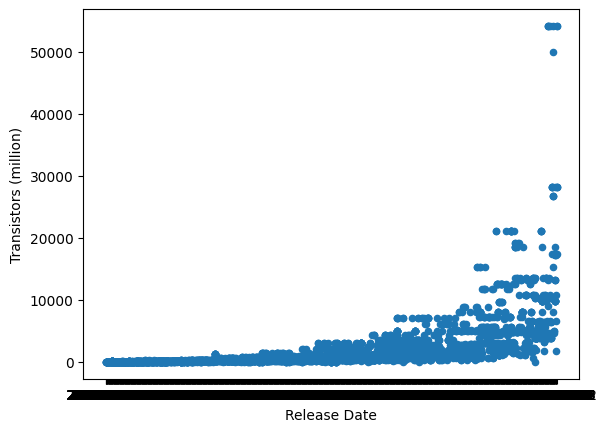

In [ ]:
chips_df.sort_values(by='Release Date').plot(kind = 'scatter', x="Release Date", y="Transistors (million)")

First, I will begin by analyzing the entire dataset, both CPUs and GPUs.

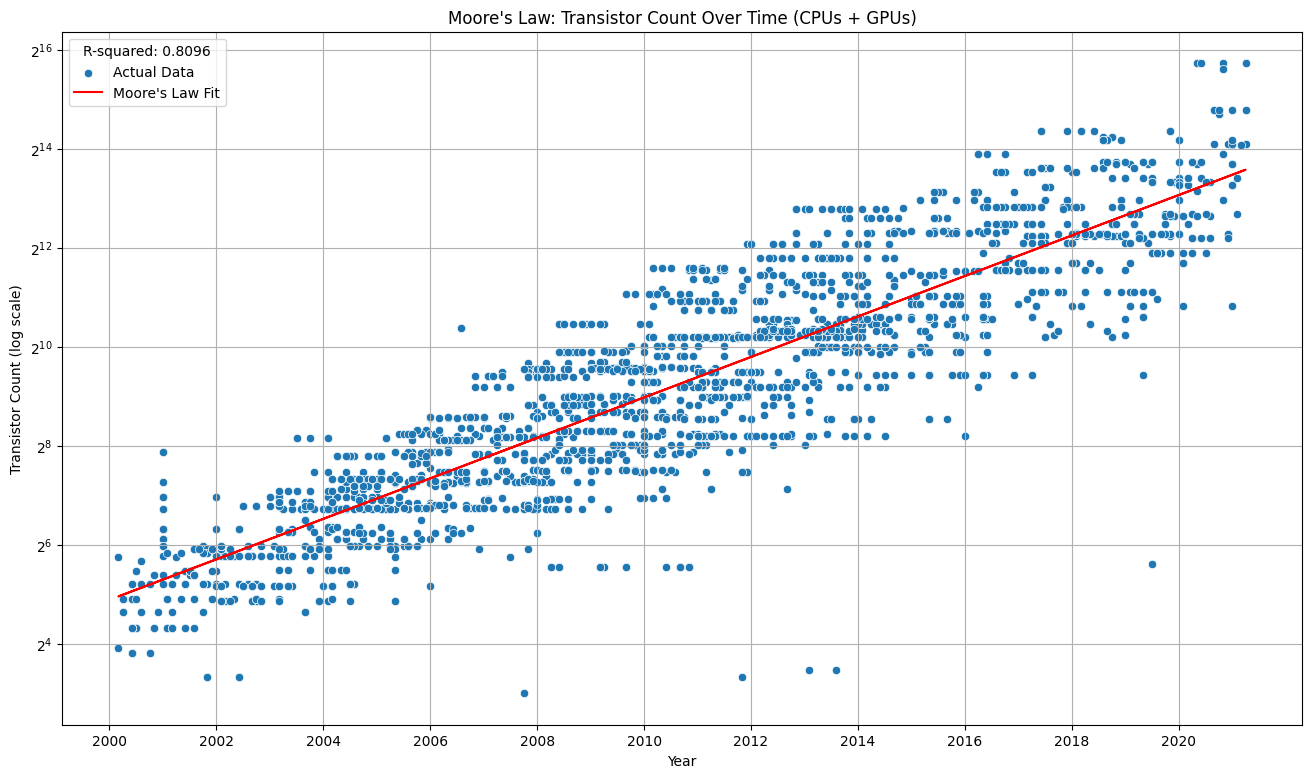

In [ ]:
# Disclaimer: much of this code was generated using artificial intelligence.
# However, I don't find that educationally useful, so I decided to work through
# it with the AI to try and understand what it generated. As I learned more,
# I worked with the AI to slim down the code and correct its mistakes. I have 
# also spent a significant amount of time towards annotating and explaining 
# its code to the best of my ability. I hope this is sufficient. AI was not used
# in the creation of my Medium post (I do not trust artificial intelligence
# with creative writing tasks).

# The logarithmic transformation I performed earlier turned my data from exponential
# data into linear data. Due to this, I can perform a linear regression on this
# data using the method below. According to the scipy docs, this function 
# calculates "a linear least-squares regression for two sets of measurements."

slope, intercept, r_value, p_value, std_err = linregress(chips_df['Year'], chips_df['Log Transistor Count'])

# This generates the predicted number of transistors, log-transformed, using
# the slope generated by the function above.
predicted_log_transistors = slope * chips_df['Year'] + intercept

# This converts the predicted transistors above, which is log-transformed data,
# back to raw numbers. This is then plotted on the plot below, because the
# entire plot is log-transformed to allow for the raw values to be plotted and
# the scale to be adjusted properly
predicted_transistors = np.exp2(predicted_log_transistors)

# Plot data and Moore's Law trend
plt.figure(figsize=(16, 9))
sns.scatterplot(x=chips_df['Year'], y=chips_df['Transistors (million)'], label='Actual Data')
plt.plot(chips_df['Year'], predicted_transistors, color='red', label="Moore's Law Fit")
plt.yscale('log', base=2)
plt.xlabel('Year')
plt.ylabel('Transistor Count (log scale)')
plt.title("Moore's Law: Transistor Count Over Time (CPUs + GPUs)")
plt.xticks(np.arange(int(chips_df['Year'].min()), int(chips_df['Year'].max()) + 1, 2))
# The r-value below basically indicates how closely each axis of the data is 
# correlated to one another. A score of 0.81 is considered a "very strong" 
# positive correlation according to LibreTexts Statistics:
# https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Statistics%3A_Open_for_Everyone_(Peter)/12%3A_Bivariate_Correlation/12.05%3A_Interpretation_of_r-Values
plt.legend(title=f"R-squared: {r_value**2:.4f}")
plt.grid()
plt.show()

As you can see, the data broadly conforms to Moore's law over the past 20 years. This is backed up by the data's R-value, 0.81, indicating a strong positive correlation between the dependent and independent variables.

Next, I will analyze CPUs specifically:

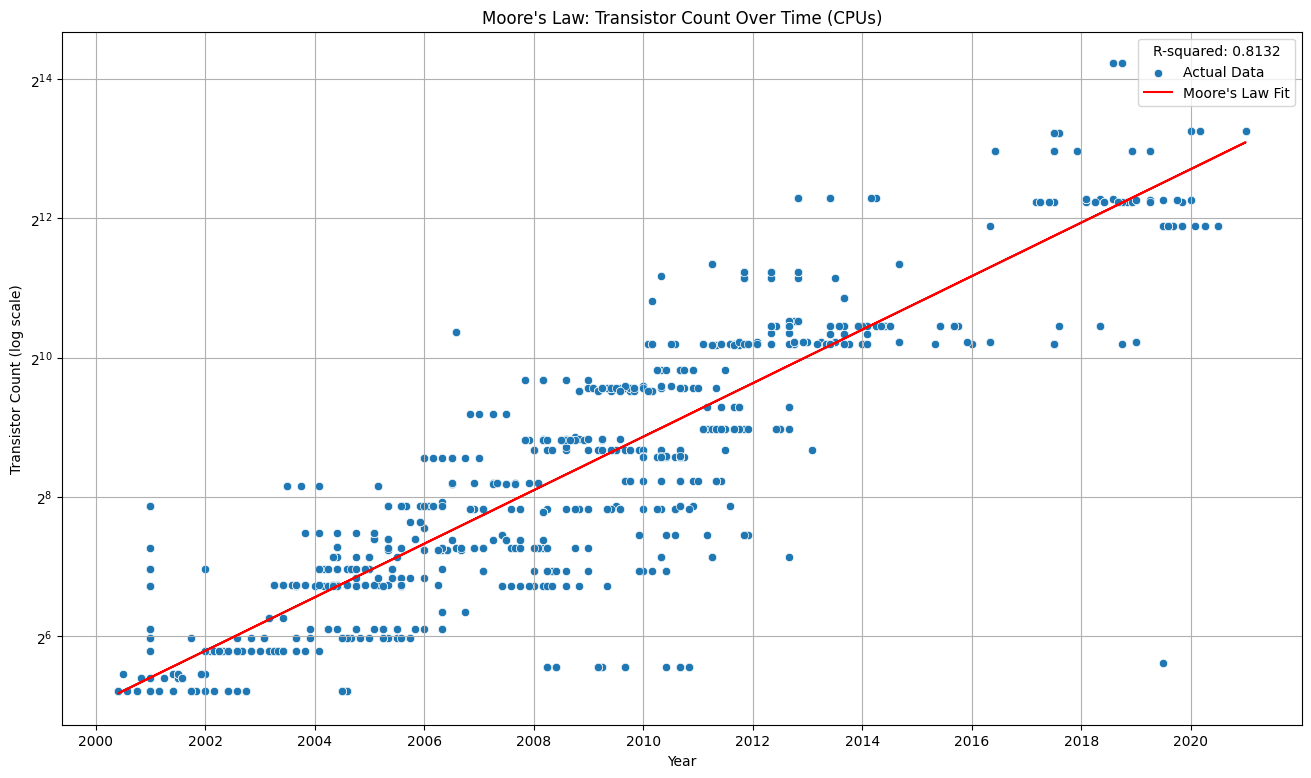

In [ ]:
# The logarithmic transformation I performed earlier turned my data from exponential
# data into linear data. Due to this, I can perform a linear regression on this
# data using the method below. According to the scipy docs, this function 
# calculates "a linear least-squares regression for two sets of measurements."

slope, intercept, r_value, p_value, std_err = linregress(cpu_df['Year'], cpu_df['Log Transistor Count'])

# This generates the predicted number of transistors, log-transformed, using
# the slope generated by the function above.
predicted_log_transistors = slope * cpu_df['Year'] + intercept

# This converts the predicted transistors above, which is log-transformed data,
# back to raw numbers. This is then plotted on the plot below, because the
# entire plot is log-transformed to allow for the raw values to be plotted and
# the scale to be adjusted properly
predicted_transistors = np.exp2(predicted_log_transistors)

# Plot data and Moore's Law trend
plt.figure(figsize=(16, 9))
sns.scatterplot(x=cpu_df['Year'], y=cpu_df['Transistors (million)'], label='Actual Data')
plt.plot(cpu_df['Year'], predicted_transistors, color='red', label="Moore's Law Fit")
plt.yscale('log', base=2)
plt.xlabel('Year')
plt.ylabel('Transistor Count (log scale)')
plt.title("Moore's Law: Transistor Count Over Time (CPUs)")
plt.xticks(np.arange(int(cpu_df['Year'].min()), int(cpu_df['Year'].max()) + 1, 2))
# The r-value below basically indicates how closely each axis of the data is 
# correlated to one another. A score of 0.81 is considered a "very strong" 
# positive correlation according to LibreTexts Statistics:
# https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Statistics%3A_Open_for_Everyone_(Peter)/12%3A_Bivariate_Correlation/12.05%3A_Interpretation_of_r-Values
plt.legend(title=f"R-squared: {r_value**2:.4f}")
plt.grid()
plt.show()

CPUs seem to be similarly compliant with Moore's law. As with the dataset at large, there is also a 0.81 R-squared value for this subset of the dataset.

Lastly, I will look at the GPU side of things:

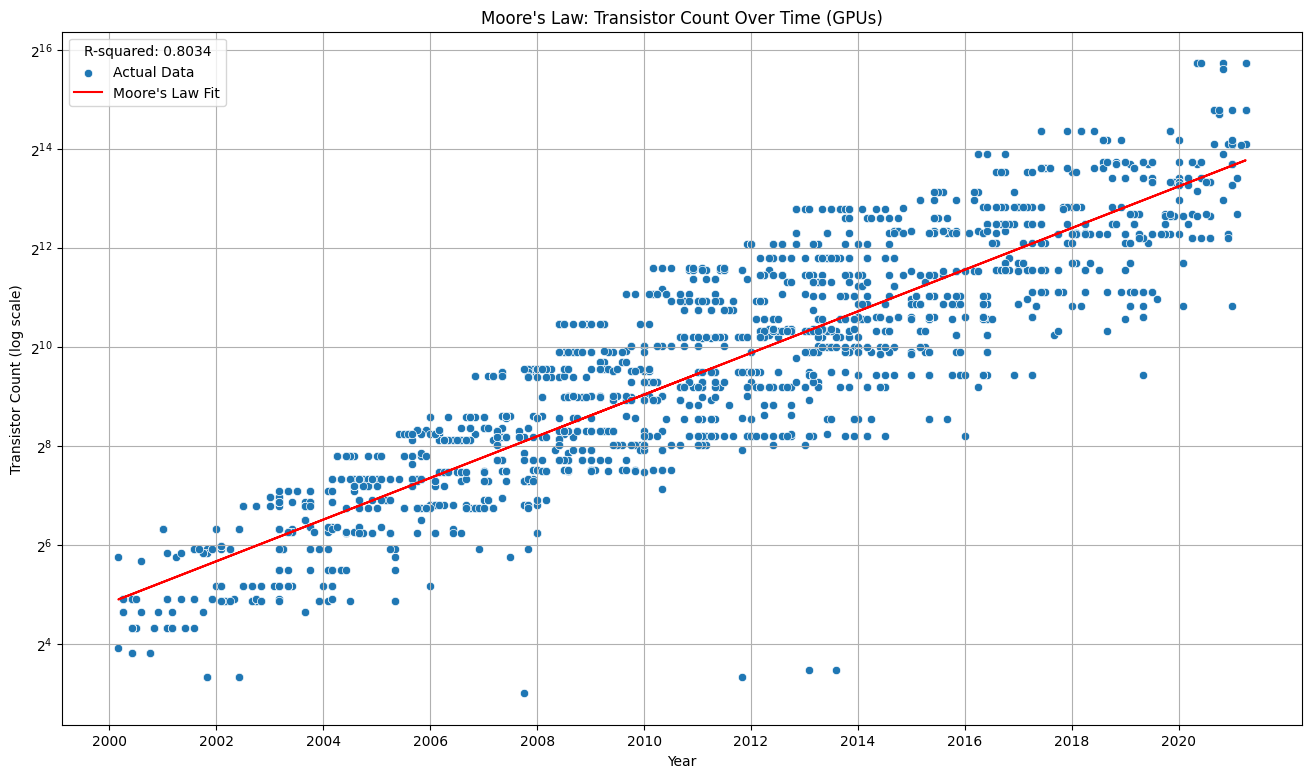

In [ ]:
# The logarithmic transformation I performed earlier turned my data from exponential
# data into linear data. Due to this, I can perform a linear regression on this
# data using the method below. According to the scipy docs, this function 
# calculates "a linear least-squares regression for two sets of measurements."

slope, intercept, r_value, p_value, std_err = linregress(gpu_df['Year'], gpu_df['Log Transistor Count'])

# This generates the predicted number of transistors, log-transformed, using
# the slope generated by the function above.
predicted_log_transistors = slope * gpu_df['Year'] + intercept

# This converts the predicted transistors above, which is log-transformed data,
# back to raw numbers. This is then plotted on the plot below, because the
# entire plot is log-transformed to allow for the raw values to be plotted and
# the scale to be adjusted properly
predicted_transistors = np.exp2(predicted_log_transistors)

# Plot data and Moore's Law trend
plt.figure(figsize=(16, 9))
sns.scatterplot(x=gpu_df['Year'], y=gpu_df['Transistors (million)'], label='Actual Data')
plt.plot(gpu_df['Year'], predicted_transistors, color='red', label="Moore's Law Fit")
plt.yscale('log', base=2)
plt.xlabel('Year')
plt.ylabel('Transistor Count (log scale)')
plt.title("Moore's Law: Transistor Count Over Time (GPUs)")
plt.xticks(np.arange(int(gpu_df['Year'].min()), int(gpu_df['Year'].max()) + 1, 2))
# The r-value below basically indicates how closely each axis of the data is 
# correlated to one another. A score of 0.81 is considered a "very strong" 
# positive correlation according to LibreTexts Statistics:
# https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Statistics%3A_Open_for_Everyone_(Peter)/12%3A_Bivariate_Correlation/12.05%3A_Interpretation_of_r-Values
plt.legend(title=f"R-squared: {r_value**2:.4f}")
plt.grid()
plt.show()

This subset has a marginally lower R-squared value, but it is still >=0.8, so this dataset still retains a strong positive correlation in line with Moore's Law.

Overall, I'd say that this exploratory data analysis largely confirms that Moore's law still applies today.